In [0]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ls

base_dir/  HAM10000_metadata.csv  model.json  prediction/  test.ipynb


In [0]:
# The model for the skin cancer classifier

# Import the libraries
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# Check if GPU is available
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
#The paths for the training and validation images
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

# Declare a few useful values
num_train_samples = 9013
num_val_samples = 1002
train_batch_size = 10
val_batch_size = 10
image_size = 224

# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [0]:

# Set up generators
train_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=train_batch_size)

valid_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size)

test_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False)

print(valid_batches.class_indices)


Found 38710 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [0]:

# Create a MobileNet model
mobile = keras.applications.mobilenet.MobileNet()

# See a summary of the layers in the model
mobile.summary()

# Modify the model
# Exclude the last 5 layers of the model
x = mobile.layers[-6].output
# Add a dropout and dense layer for predictions
x = Dropout(0.20)(x)
predictions = Dense(7, activation='softmax')(x)

# Create a new model with the new outputs
model = Model(inputs=mobile.input, outputs=predictions)

# See a summary of the new layers in the model
model.summary()

#Save the model as a json file
model_json = model.to_json()
with open("model.json", "w") as j_file:
    j_file.write(model_json)

# Freeze the weights of the layers that we aren't training (training the last 23)
for layer in model.layers[:-23]:
    layer.trainable = False



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

Epoch 1/60
 - 2916s - loss: 1.6658 - categorical_accuracy: 0.6491 - top_2_accuracy: 0.8385 - top_5_accuracy: 0.9918 - val_loss: 2.8973 - val_categorical_accuracy: 0.1188 - val_top_2_accuracy: 0.4481 - val_top_5_accuracy: 0.9581

Epoch 00001: val_top_5_accuracy improved from -inf to 0.95808, saving model to model.h5
Epoch 2/60
 - 2786s - loss: 1.3679 - categorical_accuracy: 0.7010 - top_2_accuracy: 0.8778 - top_5_accuracy: 0.9959 - val_loss: 2.0128 - val_categorical_accuracy: 0.2814 - val_top_2_accuracy: 0.7166 - val_top_5_accuracy: 0.9621

Epoch 00002: val_top_5_accuracy improved from 0.95808 to 0.96208, saving model to model.h5
Epoch 3/60
 - 2700s - loss: 1.2563 - categorical_accuracy: 0.7325 - top_2_accuracy: 0.8902 - top_5_accuracy: 0.9982 - val_loss: 1.3030 - val_categorical_accuracy: 0.5309 - val_top_2_accuracy: 0.8014 - val_top_5_accuracy: 0.9810

Epoch 00003: val_top_5_accuracy improved from 0.96208 to 0.98104, saving model to model.h5
Epoch 4/60
 - 2371s - loss: 1.1110 - catego

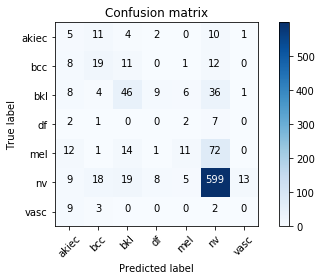

In [0]:
# Train the model
# Define Top2 and Top5 Accuracy
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

# Compile the model
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=[categorical_accuracy , top_2_accuracy, top_5_accuracy ])

# Add weights to make the model more sensitive to melanoma
class_weights={
    0: 2.0,  # akiec
    1: 2.0,  # bcc
    2: 2.0,  # bkl
    3: 2.0,  # df
    4: 2.0,  # mel
    5: 0.5,  # nv
    6: 2.0,  # vasc
}

# Declare the filepath for the saved model
filepath = "model.h5"

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_top_5_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_top_5_accuracy', factor=0.2, patience=2,
                              verbose=1, mode='max', min_lr=0.001)

callbacks_list = [checkpoint, reduce_lr]

# Fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=60,
                              verbose=2,
                              callbacks=callbacks_list)

# Evaluate the model
# Evaluation of the last epoch
val_loss, val_cat_acc, val_top_2_acc,val_top_5_acc  = \
model.evaluate_generator(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_5_acc:', val_top_5_acc)

# Evaluation of the best epoch
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc,val_top_5_acc = \
model.evaluate_generator(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_5_acc:', val_top_5_acc)

# Create a confusion matrix of the test images
test_labels = test_batches.classes

# Make predictions
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)
